# Bark Images Classification

In this classification CNN model. We have been provided with the dataseet of bark images of trees of 50 different types. This models aims to classify these bark images into its respective categories.

### Importing Libraries

In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np

**Tensorflow** - Deep Learning Network Framework by google - To implement our CNN

**Keras** -  Keras is a high-level, deep learning API developed by Google for implementing neural networks

**Matplotlib** - Library to plot charts and graphs

**Numpy**- Library for numerical and scientific calculations


### Image Size 
Here we have declared image size i.e. 303, 404 and channels represent the different color channel that are Red, Green, Blue.

Batch_size here represents the number of images in each training slot.

Epoch stands for how many training times we are going to train the model using the whole dataset

In [2]:
IMAGE_SIZE = [303, 404]
BATCH_SIZE = 30
CHANNELS = 3
EPOCHS = 70

### Inputing the dataset 

We have the dataset input and have shuffled the order of images in the dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            'BarkVN-50\BarkVN-50_mendeley',
            shuffle=True,
            image_size = IMAGE_SIZE,
            batch_size = BATCH_SIZE
            )

Found 5578 files belonging to 50 classes.


The dataset contains 5578 images classified into 50 classes that are listed below

In [4]:
class_names = dataset.class_names
class_names

['Acacia',
 'Adenanthera microsperma',
 'Adenium species',
 'Anacardium occidentale',
 'Annona squamosa',
 'Artocarpus altilis',
 'Artocarpus heterophyllus',
 'Barringtonia acutangula',
 'Cananga odorata',
 'Carica papaya',
 'Casuarina equisetifolia',
 'Cedrus',
 'Chrysophyllum cainino',
 'Citrus aurantiifolia',
 'Citrus grandis',
 'Cocos nucifera',
 'Dalbergia oliveri',
 'Delonix regia',
 'Dipterocarpus alatus',
 'Erythrina fusca',
 'Eucalyptus',
 'Ficus microcarpa',
 'Ficus racemosa',
 'Gmelina arborea Roxb',
 'Hevea brasiliensis',
 'Hopea',
 'Khaya senegalensis',
 'Khaya senegalensis A.Juss',
 'Lagerstroemia speciosa',
 'Magnolia alba',
 'Mangifera',
 'Melaleuca',
 'Melia azedarach',
 'Musa',
 'Nephelium lappaceum',
 'Persea',
 'Polyalthia longifolia',
 'Prunnus',
 'Prunus salicina',
 'Psidium guajava',
 'Pterocarpus macrocarpus',
 'Senna siamea',
 'Spondias mombin L',
 'Syzygium nervosum',
 'Tamarindus indica',
 'Tectona grandis',
 'Terminalia catappa',
 'Veitchia merrilli',
 'Wrig

In [5]:
len(dataset)

186

Length of the dataset represents the number of batch having the batch size = 35 since 35 * 160 = 5600.
In this the last batch will be having 13 images 

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(30, 303, 404, 3)
[34  6  6 12 26 43 44 35 15 40 21 21 25 33 10 22 19 42  1 15 36  5 36 28
 38 27  9  7 38  8]


Here we have picked a batch containing 35 images with the shape given as (35, 303, 404, 3) batchsize, imagesize, color channels
Below are the labels or classes of the respective images in the batch

### Plotting the images


Here we have plotted random samples of images using matplotlib and labelled their classes

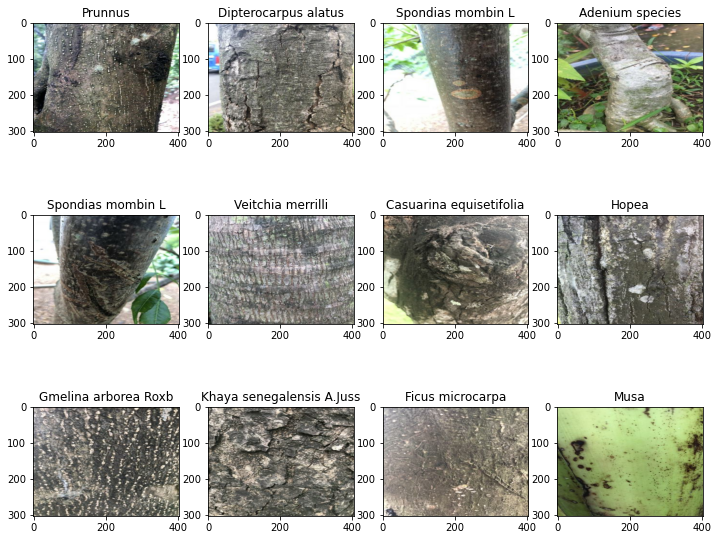

In [7]:
plt.figure(figsize = (12,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

### Shuffling and distribution of data

Here we have shuffled and distributed the dataset into training, testing and validation set using customised function
The function takes input of the dataset and the ratios of the splitting into validation and testing
Shuffle argument is reponsible for shuffling of dataset if it is True
Shuffle size will be taking random entries in the size of shuffle_size

In [8]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 100000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed= 12)
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        return train_ds, val_ds, test_ds

#### Calling out the function

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [10]:
print(len(train_ds),len(val_ds), len(test_ds))

148 18 20


### Prefetching the datasete

Prefecting overlaps the preprocessing and model execution of a training step. While the model is executing training step **s**, the input pipeline is reading the data for step **s+1**.

Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.


In [11]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Data Normalization

Here we have cropped all the images to our default images size. 

We have resclaed our data i.e. recaled our data divided each value by 255. This reduces computational cost and if efficient for the model as well. 

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE[0],IMAGE_SIZE[1]),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

Here we have created more samples from our dataset for better training and robust system. We have implement horizontal and vertical flips of the dataset set along with rotation. This process is called data augmentation and it helps in making the model more robust

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE[0],IMAGE_SIZE[1], CHANNELS)
n_classes = 50

### Architecture of the model

**Conv2D** -  Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.

**MaxPooling** - Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map. 

**Flatten** - Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector.

**Dense** - A dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer. 

We have used Sequential to stack our architecture of our classification CNN model. Resize to pass the images of input size width and rescale their pixel values. Data Augmentation has been done to increase the robustness of the model. We have implemented a total of 6 CNN layers with kernel size - (3,3) and activation as 'ReLu'.

Lastely we have flatten out the array using Flatten and Densely connected the layer with 64 neurons and then to a dense layer with neurons equal to our classes i.e. 50. The last dense layer uses softmax as its activation function to predict the probability of the class.

In [15]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
    
])

model.build(input_shape = input_shape)

### Summary of the model
Describes the parameters to be trained in each steps giving out their details.
Also gives info about total number of trainable parameters and non-trainable parameters.

A total 387,634 trainable parameters is going to be trained by the model to predict the bark images' class.

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 303, 404, 3)         0         
                                                                 
 sequential_1 (Sequential)   (30, 303, 404, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 301, 402, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (30, 150, 201, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (30, 148, 199, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (30, 74, 99, 64)         0         
 2D)                                                  

I have tried different architecture and turns out the 6 CNN layer is giving maximum efficiency

### Compilation of the model
Here we decide the optimization algorithm to be used,losses and metrics for accuracy

Here we have used most popular optimizatio algorithm ie Adam algorithm. I have tried different learning learning rates and for higher learning rates the model keeps jumping and does not converge to optimum value. Hence default value 0.001 is set to the learning rate.

For losses we have used the SparseCategoricalCrossentropy - using sparse categorical cross entropy is it saves time in memory as well as computation because it simply uses a single integer for a class, rather than a whole vector.

For metrics we have used Accuracy - it is the measure of all the correctly identified cases. Since in this case all the classes are equally important.

In [17]:
model.compile(
optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
metrics = ['accuracy'])

We are training our model on local gpu with epochs as 70

In [18]:
with tf.device('/gpu:0'):
    history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1, 
    validation_data = val_ds)

Epoch 1/70
148/148 [==============================] - 149s 705ms/step - loss: 3.9034 - accuracy: 0.0419 - val_loss: 3.8964 - val_accuracy: 0.0370
Epoch 2/70
148/148 [==============================] - 107s 603ms/step - loss: 3.8911 - accuracy: 0.0439 - val_loss: 3.8736 - val_accuracy: 0.0537
Epoch 3/70
148/148 [==============================] - 106s 599ms/step - loss: 3.6970 - accuracy: 0.0757 - val_loss: 3.4792 - val_accuracy: 0.0796
Epoch 4/70
148/148 [==============================] - 103s 574ms/step - loss: 3.1670 - accuracy: 0.1363 - val_loss: 2.8307 - val_accuracy: 0.2019
Epoch 5/70
148/148 [==============================] - 104s 580ms/step - loss: 2.9137 - accuracy: 0.1865 - val_loss: 2.7325 - val_accuracy: 0.1944
Epoch 6/70
148/148 [==============================] - 100s 563ms/step - loss: 2.7669 - accuracy: 0.2100 - val_loss: 2.6804 - val_accuracy: 0.2361
Epoch 7/70
148/148 [==============================] - 234s 572ms/step - loss: 2.6054 - accuracy: 0.2548 - val_loss: 2.6249 -

148/148 [==============================] - 77s 449ms/step - loss: 0.5390 - accuracy: 0.8328 - val_loss: 0.7756 - val_accuracy: 0.7815
Epoch 58/70
148/148 [==============================] - 81s 454ms/step - loss: 0.5568 - accuracy: 0.8202 - val_loss: 0.6770 - val_accuracy: 0.7685
Epoch 59/70
148/148 [==============================] - 81s 456ms/step - loss: 0.5626 - accuracy: 0.8169 - val_loss: 0.5812 - val_accuracy: 0.8111
Epoch 60/70
148/148 [==============================] - 81s 452ms/step - loss: 0.5249 - accuracy: 0.8279 - val_loss: 0.5336 - val_accuracy: 0.8278
Epoch 61/70
148/148 [==============================] - 80s 451ms/step - loss: 0.4859 - accuracy: 0.8453 - val_loss: 0.4119 - val_accuracy: 0.8722
Epoch 62/70
148/148 [==============================] - 79s 451ms/step - loss: 0.5243 - accuracy: 0.8324 - val_loss: 0.9238 - val_accuracy: 0.7241
Epoch 63/70
148/148 [==============================] - 78s 454ms/step - loss: 0.5031 - accuracy: 0.8348 - val_loss: 0.5973 - val_accurac

We have evaluated our model on test dataset and recorded the accuracy in models

In [19]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 16s 192ms/step - loss: 0.3705 - accuracy: 0.8930


In [20]:
history

History.params gives out the details of verbose, epochs and steps

In [21]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 148}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

List out all accuracy for each epoch

In [23]:
history.history['accuracy']

[0.041910771280527115,
 0.0439189188182354,
 0.07567567378282547,
 0.13632266223430634,
 0.18648648262023926,
 0.2100045084953308,
 0.2548445165157318,
 0.26554054021835327,
 0.2936936914920807,
 0.3292023539543152,
 0.361261248588562,
 0.39544838666915894,
 0.42248761653900146,
 0.444369375705719,
 0.47363677620887756,
 0.5261261463165283,
 0.5130689740180969,
 0.5504732131958008,
 0.5650901198387146,
 0.5646687746047974,
 0.5923839807510376,
 0.6284362077713013,
 0.6301801800727844,
 0.6369986534118652,
 0.6606579422950745,
 0.6509689092636108,
 0.6534475088119507,
 0.6605855822563171,
 0.683190643787384,
 0.6892744302749634,
 0.6909909844398499,
 0.7065315246582031,
 0.7212708592414856,
 0.7144144177436829,
 0.7363677620887756,
 0.7386209964752197,
 0.7334384918212891,
 0.755630612373352,
 0.7686936855316162,
 0.7525912523269653,
 0.762054979801178,
 0.7658855319023132,
 0.777151882648468,
 0.7827850580215454,
 0.7712934017181396,
 0.788192868232727,
 0.7929247617721558,
 0.79968452

Here we labelling accuracy and loss for training and validation dataset.

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Plotting graph between training validation and training accuracy against epochs

Here the graph raises steeply over the epochs to attain optimum value. Hence it shows that model is performing great.

Text(0.5, 1.0, 'Training and Validation Accuracy')

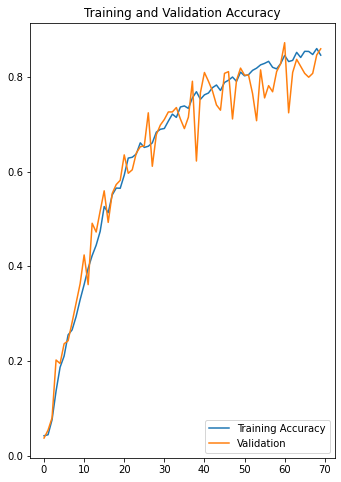

In [25]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

### Predicting random samples from test dataset

Defined a function that takes an image and model as input and converts the image to array and predict it using the trained model.

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

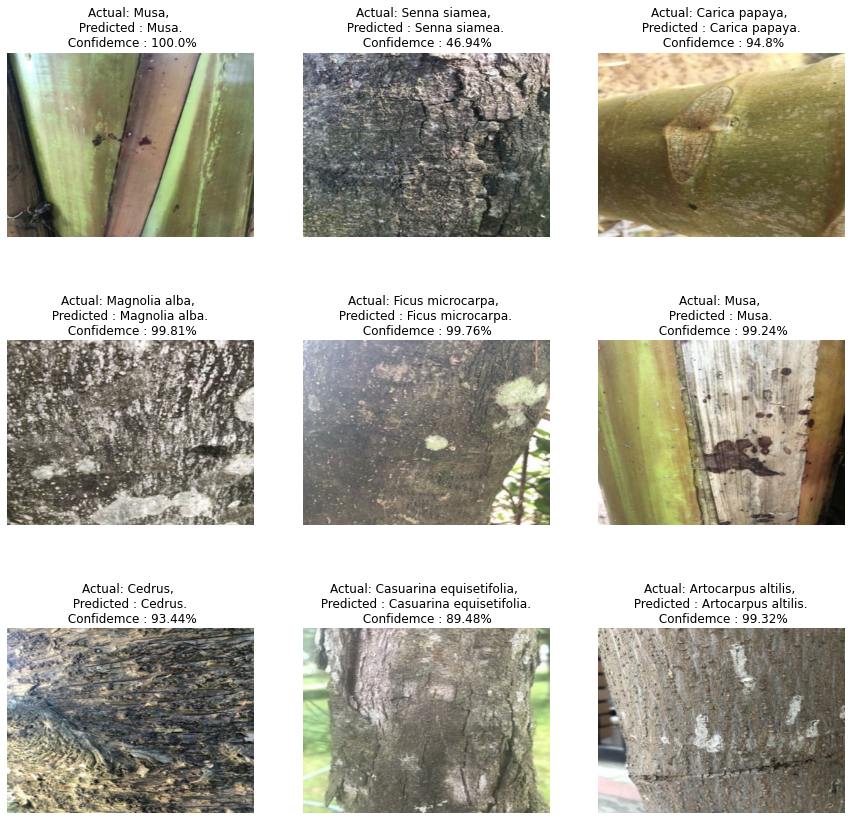

In [29]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class}. \n Confidemce : {confidence}%")
        plt.axis("off")

#### Our model has achieved approximately 85% accuracy !

The accuracy can be increased by tweaking epochs and deeping the CNN architecture by using powerful GPUs. 